# 1/2 manually build map

In [1]:
import rosbag
import math
import numpy as np
import statistics as sta
import enum

'''gps'''
import utm
from pyproj import Proj
import shapefile

'''plot tool'''
import matplotlib.pyplot as plt

'''image tool'''
import cv2

In [2]:
bag_source_dir = '/home/ncslaber/110-1/211002_allLibrary/image_bag/'
file_name = {'middle':'2021-10-02-17-54-09', 'front_right':'2021-10-02-17-03-14', 
            'middle_right':'2021-10-02-17-29-15', 'back_left':'2021-10-03-17-48-23', 'front_left':'2021-07-25-18-23-39'}
lat_dict = {}
lng_dict = {}
for item in file_name.keys():
    try:

        topics = ['/navsat/fix']
        
        bag_source_file = bag_source_dir + file_name[item] + '.bag'
        print('Start reading: {}'.format(bag_source_file))
        bag = rosbag.Bag(bag_source_file, 'r')
        
        lat_dict[item] = list()
        lng_dict[item] = list()
        
        for topic, msg, t in bag.read_messages(topics=topics):
            if topic == '/navsat/fix':
                if not math.isnan(msg.latitude) and not math.isnan(msg.longitude):
                    lat_dict[item].append(msg.latitude)
                    lng_dict[item].append(msg.longitude)
                else:
                    print(msg.latitude, msg.longitude)

                   
        bag.close()
                
    except:
            print('error with: {}'.format(bag_source_file)) 

Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-10-02-17-54-09.bag
Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-10-02-17-03-14.bag
Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-10-02-17-29-15.bag
Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-10-03-17-48-23.bag
Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-07-25-18-23-39.bag


In [3]:
def get_init_utm_npy(lat, lng):
    
    _, _, zone, R = utm.from_latlon(lat[0], lng[0])
    proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
    utm_x_ref, utm_y_ref = proj(lng, lat)
    
    return utm_x_ref, utm_y_ref

In [4]:
def traj(utm_x_traj,utm_y_traj, title):    
    '''draw with pos'''
    fig3, ax3 = plt.subplots(figsize=(5, 5),dpi=80)
    plt.grid(True)
    plt.axis('equal')
    plt.plot(utm_x_traj,utm_y_traj,'-o',c='black',label='preset positive bd')
    ax3.get_xaxis().get_major_formatter().set_useOffset(
            round(min(utm_x_traj) / 1000, 2)*1000)
    plt.ylabel('UTM Y [m]', fontsize=18)
    plt.xticks(fontsize=15 )
    plt.xlabel('UTM X [m]', fontsize=18)
    plt.yticks(fontsize=15 )
    plt.axis('equal', fontsize=18)
    plt.title(title)
    plt.show()

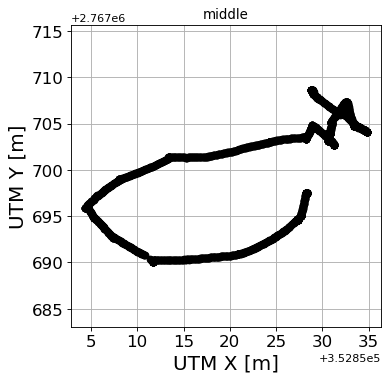

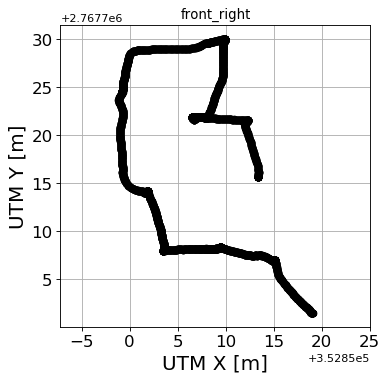

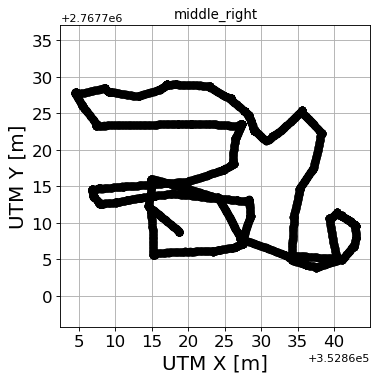

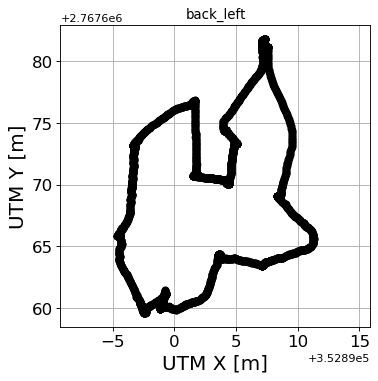

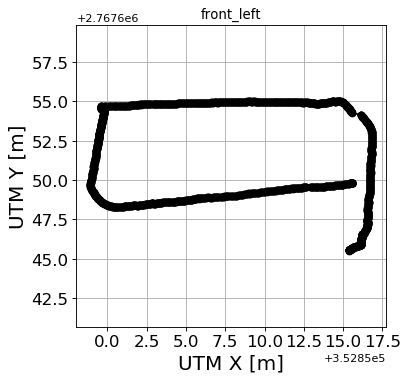

In [5]:
for item in lat_dict.keys():
    utm_x_traj, utm_y_traj = get_init_utm_npy(lat_dict[item], lng_dict[item])
    traj(utm_x_traj,utm_y_traj, item)

In [6]:
def cvt_gray_map(raw_pgm):
    map_canvas = np.zeros(raw_pgm.shape, dtype='uint8')
    map_canvas = map_canvas + 255
    map_canvas[np.logical_and(raw_pgm<256, raw_pgm>249)] = 205
    map_canvas[raw_pgm==0] = 0
#     plt.imshow(cv2.cvtColor(map_canvas, cv2.COLOR_BGR2RGB))
#     plt.show()
    return map_canvas

pgm height is:  2048


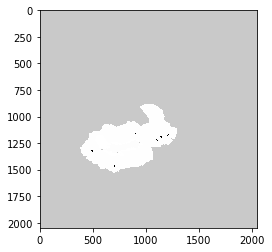

pgm height is:  2048


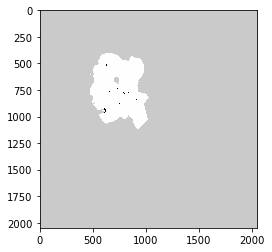

pgm height is:  2048


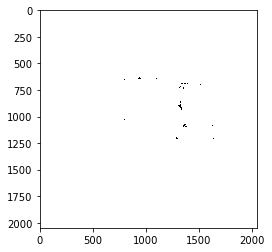

pgm height is:  2048


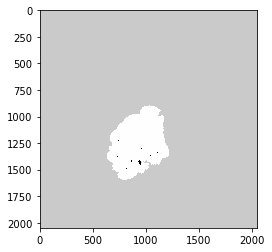

pgm height is:  2048


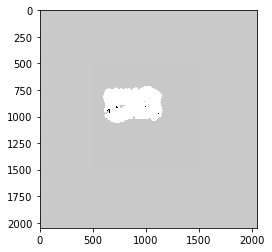

In [7]:
raw_pgm_dict = {}
for item in lat_dict.keys():
    map_source_dir = '/home/ncslaber/110-1/211002_allLibrary/'
    file_path = map_source_dir + '/' + file_name[item] 
    raw_pgm = cv2.imread(file_path+"/1116_test2_after_preprocess/raw_modified.png")
    if raw_pgm is None:
        print("Image is empty!!")
    raw_pgm = cv2.cvtColor(raw_pgm, cv2.COLOR_RGB2GRAY)
    raw_pgm_cvt = cvt_gray_map(raw_pgm)
    raw_pgm_dict[item] = raw_pgm_cvt
    (width, height) = raw_pgm.shape # the order is right
    print("pgm height is: ",height)
    # raw_pgm = cv2.resize(raw_pgm, (1024, 1024), interpolation=cv2.INTER_AREA)
    plt.imshow(cv2.cvtColor(raw_pgm, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
num = (raw_pgm_dict['middle'][raw_pgm_dict['middle']==0]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==255]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==254]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==253]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==251]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==203]).shape[0]

num, 2048*2048

(3881731, 4194304)

## check relative position

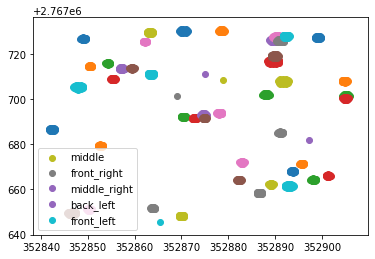

({'middle': [352878.8862176978],
  'front_right': [352869.03876166826],
  'middle_right': [352874.9314219437],
  'back_left': [352897.338491822],
  'front_left': [352865.3782908574]},
 {'middle': [2767708.6000474878],
  'front_right': [2767701.4516908275],
  'middle_right': [2767711.122274709],
  'back_left': [2767681.8378069475],
  'front_left': [2767645.5600058394]})

In [9]:
utm_start_x_dict = {}
utm_start_y_dict = {}
num_trunk = [8,8,16,9,4]
for index, item in enumerate(file_name.keys()):
    shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
    for i in range(num_trunk[index]):
        neg_bd = np.load(shp_path+'neg_'+str(i+1)+'_bd_utm.npy')
        plt.scatter(neg_bd[:,0], neg_bd[:,1])

    lat_start = np.mean(lat_dict[item][:25])
    lng_start = np.mean(lng_dict[item][:25])
    utm_start_x, utm_start_y = get_init_utm_npy([lat_start], [lng_start])
    utm_start_x_dict[item] = utm_start_x
    utm_start_y_dict[item] = utm_start_y
    plt.scatter(utm_start_x, utm_start_y, label=item)
    
plt.legend()
plt.show()
utm_start_x_dict, utm_start_y_dict

In [10]:
# num_trunk = [8,8,16]
# center_list_all = []
# for index, item in enumerate(file_name.keys()):
# #     print(index, item)
#     shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
#     for a in range(num_trunk[index]):
# #         print(num_trunk[index-1], a, list(range(num_trunk[index-1])) )
#         tmp = list(np.load(shp_path+'center_'+str(a+1)+'_bd_utm.npy'))
#         center_list_all.append(tmp)

In [11]:
# np.save('/home/ncslaber/center_list_all.npy',center_list_all)

#### change to relative coordinate

In [12]:
bd_left = utm_start_x_dict['front_right'][0]
bd_top = utm_start_y_dict['middle_right'][0]
relative_mapWorld = {}
for item in utm_start_x_dict.keys():
    relative_mapWorld[item] = \
        [round((utm_start_x_dict[item][0]-bd_left)*20), round((bd_top - utm_start_y_dict[item][0])*20)]
relative_mapWorld

{'middle': [197, 50],
 'front_right': [0, 193],
 'middle_right': [118, 0],
 'back_left': [566, 586],
 'front_left': [-73, 1311]}

## open a canvas

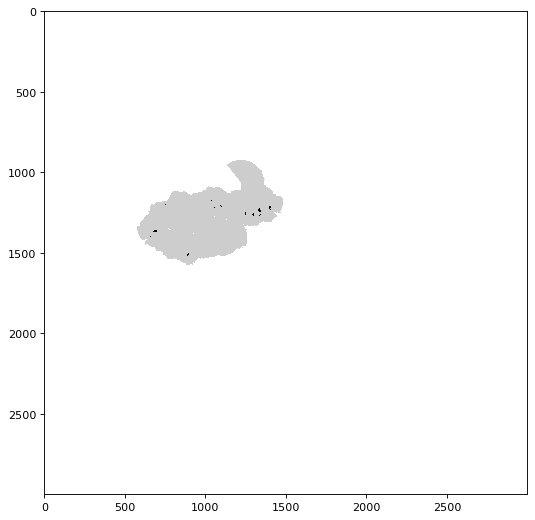

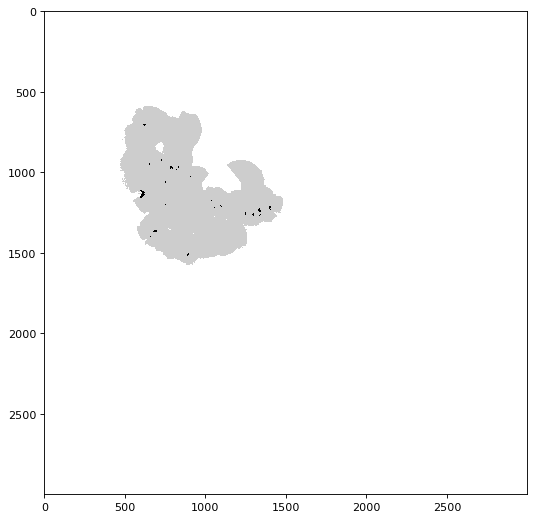

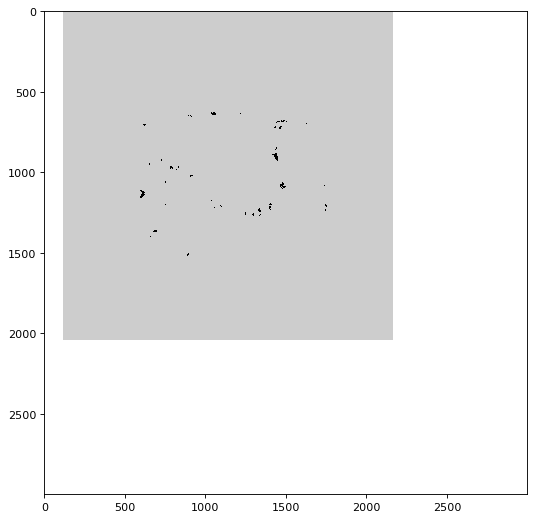

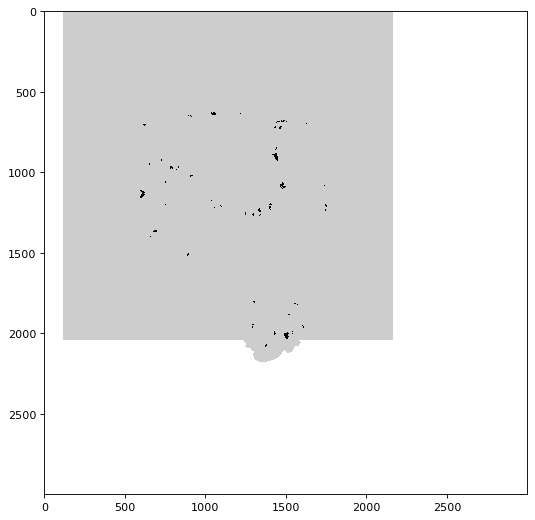

error: OpenCV(4.2.0) ../modules/core/src/arithm.cpp:232: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


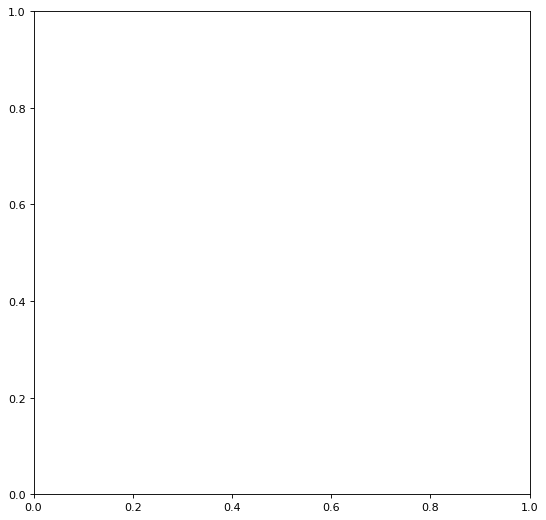

In [13]:
map_canvas = np.zeros((3000,3000), dtype='uint8')
map_canvas = map_canvas + 255
for item in utm_start_x_dict.keys():
    fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=80)
    offset_x, offset_y = relative_mapWorld[item]
    offset_x_end, offset_y_end = offset_x+2048, offset_y+2048
    map_canvas[offset_y:offset_y_end, offset_x:offset_x_end] = \
        cv2.bitwise_and(map_canvas[offset_y:offset_y_end, offset_x:offset_x_end], raw_pgm_dict[item])
    plt.imshow(cv2.cvtColor(map_canvas, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
file_path = '/home/ncslaber/110-1/211002_allLibrary/2021-07-25-18-23-39/1116_test2_after_preprocess/' #directory+bag_name
raw_pgm = cv2.imread(file_path+"raw_modified.png")
raw_pgm = cv2.cvtColor(raw_pgm, cv2.COLOR_RGB2GRAY)
tmp = np.zeros((2048,2048), dtype='uint8')+ 204

tmp[512:512+1024,512:512+1024] = raw_pgm
cv2.imwrite(file_path+"raw_modified2.png",tmp)